## Image Simulations

This notebook is a tutorial on **image simulation** for our galaxy image dataset. In our project, it is crucial that we properly generate a dataset comprised of blurred galaxy images (input) and non-blurred galaxy images (ground truth) to train and test the unrolled ADMM model. We used the modular galaxy image simulation toolkit [Galsim](https://github.com/GalSim-developers/GalSim) and the [COSMOS Real Galaxy Dataset](https://zenodo.org/record/3242143#.Ytjzki-KFAY) for our simulations. 

Our forward model is desciribed by the following equation. The distant galaxy $\mathbf{G}$ is sheared and convolved with the effective point spread function $\mathbf{PSF}$. Poisson shot noise and Gaussian read noise $\mathbf{N_r}$ are added to obtain the observed galaxy $\mathbf{\tilde{G}}$.

$\begin{equation} \mathbf{\tilde{G}} = \text{Poisson}(\text{shear}(\mathbf{G}) \otimes \mathbf{PSF}) + \mathbf{N_r} \end{equation}$

To simulate a typical **ground-based** sky survey, we used the parameters of the [**Vera C. Rubin Observatory (LSST)**](https://www.lsst.org).

In [36]:
# %pip install Galsim

import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim

%matplotlib inline

### Define Fundamental Parameters

In [37]:
fov_pixels = 48                     # number of pixels in FOV, the size of the image is (fov_pixels, fov_pixels)
pixel_scale = 0.2                   # pixel scale (aresec), determines the resolution (0.2 for LSST)

### Read out galaxy from COSMOS Real Galaxy Catalog

Download the [COSMOS Real Galaxy Dataset](https://zenodo.org/record/3242143#.Ytjzki-KFAY). Initialize the RealGalaxyCatalog and read out a galaxy with an index. Take a look at the original images and you'll notice it has a higher resolution. This is because the HST has a pixel scale of 0.05 arcsec.

Text(0.5, 1.0, 'Galaxy')

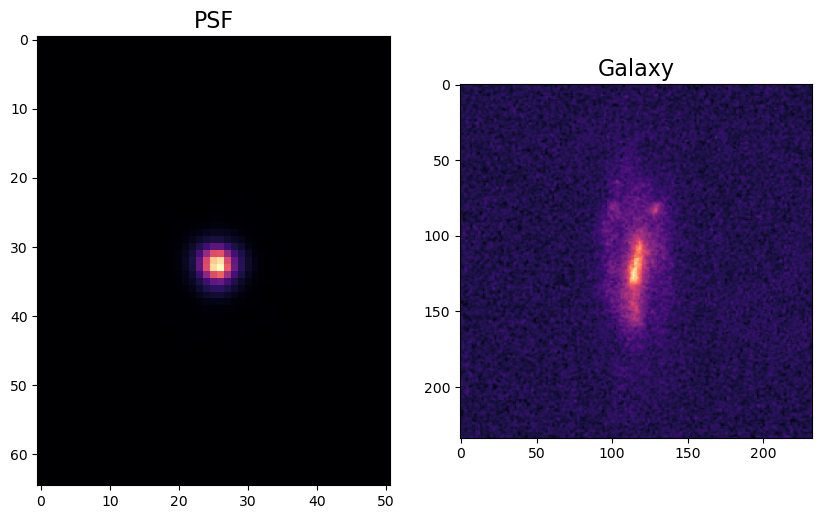

In [38]:
# Initialize catalog
# cosmos_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/' # path to your COSMOS data
COSMOS_dir = '/Users/luke/Downloads/COSMOS_23.5_training_sample' # path to your COSMOS data
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample="23.5")

# Pick a galaxy
i = 0 # randomly select a galaxy index in the catalog
gal_ori_image = real_galaxy_catalog.getGalImage(i)
psf_ori_image = real_galaxy_catalog.getPSFImage(i)

cmap = 'magma'

# Visulaize galaxy & PSF in COSMOS data
plt.figure(i,figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(psf_ori_image.array, cmap=cmap)
plt.title('PSF', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(gal_ori_image.array, cmap=cmap) 
plt.title('Galaxy', fontsize=16)

### Simulate Point Spread Function

**Point Spread Functions (PSF)** is the most crucial component in our image simulation. In our formation model, we assume the PSF consists of two components caused by the atmospheric turbulence and the optical structure of the telescope respectively to approximate a typical ground-based obseravtion. The overall PSF is the convolution of the two components:
$\begin{equation} PSF = PSF_{atmos} \otimes PSF_{optical} \end{equation}$

To add randomness in our simulation, we use the random number generator provided by Galsim. Here we initialize it with a random seed.

In [39]:
random_seed = 374                   # random seed for the rng
rng = galsim.UniformDeviate(seed=random_seed)

Set up parameters for the PSF. Most of the parameters are the same as LSST. Here we sampled the seeing form a truncated Gaussian distribution to simulate a realistic observation.

In [40]:
# Atmospheric PSF
seeing = 0.67                       # median seeing (arcsec) (0.67 for LSST)
# sample seeing form a distribution
rng_gaussian = galsim.GaussianDeviate(seed=random_seed, mean=seeing, sigma=0.18)
atmos_fwhm = 0                      # atmospheric seeing, i.e., the FWHM of the Kolmogorov function
while atmos_fwhm < 0.3 or atmos_fwhm > 1.3: # truncated Gaussian distribution
    atmos_fwhm = rng_gaussian()
atmos_max_shear = 0.2               # maximum shear of the galaxy 
atmos_e = rng() * atmos_max_shear   # ellipticity of atmospheric PSF
atmos_beta = 2. * np.pi * rng()     # radians
atmos_g1 = atmos_e * np.cos(atmos_beta)
atmos_g2 = atmos_e * np.sin(atmos_beta)

# Optical PSF
lam = 700                           # wavelength (nm)
tel_diam = 8.36                     # telescope diameter (meters) (8.36 for LSST)
opt_defocus = 0.3 + 0.4 * rng()     # defocus in units of incident light wavelength
opt_a1 = 2*0.5*(rng() - 0.5)        # astigmatism (like e1) in units of incident light wavelength
opt_a2 = 2*0.5*(rng() - 0.5)        # astigmatism (like e2) in units of incident light wavelength
opt_c1 = 2*1.*(rng() - 0.5)         # coma along y in units of incident light wavelength
opt_c2 = 2*1.*(rng() - 0.5)         # coma along x in units of incident light wavelength
opt_obscuration = 0.165             # linear dimension of central obscuration as fraction of pupil linear dimension, [0., 1.)

Now we can simulate the two PSF components respectively and convolve them together. We used the Kolmogorov function to simulate the atmospheric PSF while the optical component is an aberrated PSF caused by telescope optics. The flux for the PSFs are all 1.

In [41]:
# Atmospheric PSF
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1)
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)

# Optical PSF
lam_over_diam = lam * 1.e-9 / tel_diam # radians
lam_over_diam *= 206265  # arcsec
optics = galsim.OpticalPSF( lam_over_diam,
                        defocus = opt_defocus,
                        coma1 = opt_c1, coma2 = opt_c2,
                        astig1 = opt_a1, astig2 = opt_a2,
                        obscuration = opt_obscuration,
                        flux=1)

# Convolve the two components
psf = galsim.Convolve([atmos, optics], real_space=True)

# draw PSF image
psf_image = galsim.ImageF(fov_pixels, fov_pixels)
psf.drawImage(psf_image, scale=pixel_scale, method='auto')
psf_image = torch.from_numpy(psf_image.array)
psf_image = torch.max(torch.zeros_like(psf_image), psf_image)

### Simulate Observed Galaxy

Similarly, we choose appropriate parameters first.

In [42]:
sky_level = 1.e3                    # sky level (ADU/arcsec^2)
gal_flux = 2.5e4                    # flux of the galaxy, depends on the SNR
gal_max_shear = 0.5                 # maximum shear of galaxies
gal_e = rng() * gal_max_shear       # shear of galaxies
gal_beta = 2. * np.pi * rng()       # (radians)
gal_g1 = gal_e * np.cos(gal_beta)   # reduced shear
gal_g2 = gal_e * np.sin(gal_beta)   # reduced shear
gal_mu = 1 + rng() * 0.1            # magnification
theta = 2. * np.pi * rng()          # rotation angle (radians)
dx = rng() - 0.5                    # Offset by up to 1/2 pixel in each direction
dy = rng() - 0.5                    # Offset by up to 1/2 pixel in each direction

Then we initialize a RealGalaxy object with the real galaxy we chose in the COSMOS real galaxy catalog.

In [43]:
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, index = i, flux = gal_flux)
psf_ori = real_galaxy_catalog.getPSF(i)
gal_ori = galsim.Convolve([psf_ori, gal_ori]) # convolve wth original PSF of HST

Now we randomly rotate, shear and magnify the galaxy to simulated a real galaxy twisted by weak lensing effects. 

In [44]:
gal = gal_ori.rotate(theta * galsim.radians) # Rotate by a random angle
gal = gal.shear(e=gal_e, beta=gal_beta * galsim.radians) # Apply the desired shear
gal = gal.magnify(gal_mu) # apply a magnification, this conserves surface brightness, so it scales both the area and flux
gal_image = galsim.ImageF(fov_pixels, fov_pixels)
gal.drawImage(gal_image, scale=pixel_scale, offset=(dx,dy), method='auto')
gal_image += sky_level * (pixel_scale**2) # add sky level
gal_image = torch.from_numpy(gal_image.array)
gal_image = torch.max(torch.zeros_like(gal_image), gal_image) # set negative pixels to zero

And then convolve the galaxy with the PSF via FFT to simulate.

In [45]:
conv = ifftshift(ifft2(fft2(psf_image) * fft2(gal_image))).real # convolution via FFT
conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero

Finally we add CCD noise (Poisson + Gaussian) to get a raw image.

In [46]:
read_noise = 5                      # standrad deviation of Gaussain read noise (ADU)
obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=read_noise*torch.ones_like(conv))
obs = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero

### Draw and Plot Images

Finally we can visualize our simulated galaxy.

Text(0.5, 1.0, 'Observed Galaxy')

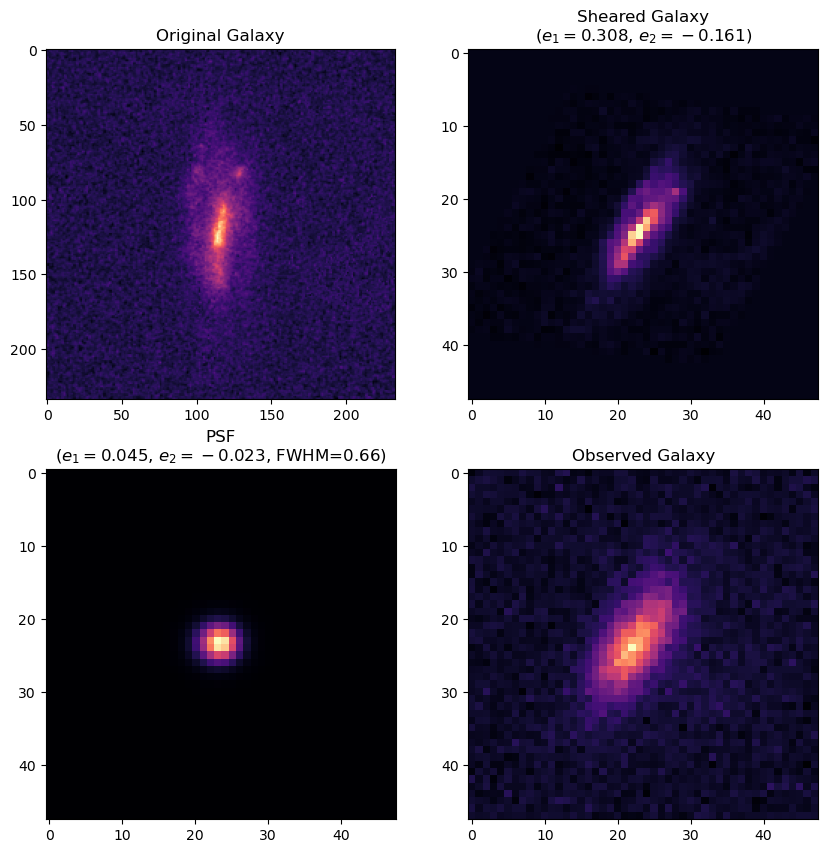

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(gal_ori_image.array, cmap=cmap)
plt.title('Original Galaxy')
plt.subplot(2,2,2)
plt.imshow(gal_image, cmap=cmap)
plt.title('Sheared Galaxy\n($e_1={:.3f}$, $e_2={:.3f}$)'.format(gal_g1, gal_g2))
plt.subplot(2,2,3)
plt.imshow(psf_image, cmap=cmap)
plt.title('PSF\n($e_1={:.3f}$, $e_2={:.3f}$, FWHM={:.2f})'.format(atmos_g1, atmos_g2, atmos_fwhm))
plt.subplot(2,2,4)
plt.imshow(obs, cmap=cmap)
plt.title('Observed Galaxy')

### Save Images for Pipeline Figure

In [48]:
plt.imsave('../figures/gal_ori_image.jpg', gal_ori_image.array, cmap=cmap)
plt.imsave('../figures/gal_image.jpg', gal_image, cmap=cmap)
plt.imsave('../figures/psf_image.jpg', psf_image[10:-10,10:-10], cmap=cmap)
plt.imsave('../figures/obs.jpg', obs, cmap=cmap)